# Using `RailEnv`

In this notebook, we will see how to create, interact with and render railway systems with `RailEnv` the flatland env class.

You can run this document as an interactive notebook in one click:

[![Open In Binder](https://mybinder.org/static/images/badge_logo.svg)](https://mybinder.org/v2/gh/MasterScrat/getting-started/master?filepath=notebook_1.ipynb)[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MasterScrat/getting-started/blob/master/notebook_1.ipynb)

## Setup
1. Install Flatland


In [1]:
!pip install -U flatland-rl

## The Environment
Let's first go over the main use cases of `RailEnv`, the Flatland environment.

The basic usage of the `RailEnv` environment consists in creating a `RailEnv` object endowed with
-  a **rail generator**, that generates new rail networks on each reset,
- an **observation generator**, that provides a suitable observation vector to the agents. 

For now, let's see how we can create rail networks and use them to train agents.



In [2]:
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import random_rail_generator

# Build a random 15x15 rail networks from a list of probability per cell type
transition_prob = [
    1.0,  # Type 0 - empty cell
    1.0,  # Type 1 - straight
    1.0,  # Type 2 - simple switch
    0.3,  # Type 3 - diamond crossing
    0.5,  # Type 4 - single slip
    0.5,  # Type 5 - double slip
    0.2,  # Type 6 - symmetrical
    0.0,  # Type 7 - dead end
    0.2,  # Type 8 - turn left
    0.2,  # Type 9 - turn right
    1.0  # Type 10 - mirrored switch
]

rail_generator = random_rail_generator(cell_type_relative_proportion=transition_prob)

random_env = RailEnv(
    width=15,
    height=15,
    rail_generator=rail_generator,
    number_of_agents=1
)

# Call reset() to initialize the environment
observation, info = random_env.reset()

## Visualising the env

You can use the method `RenderTool.render_env()` to render the env in realtime.

For the sake of this tutorial we define a helper function for inline visualization in the notebook

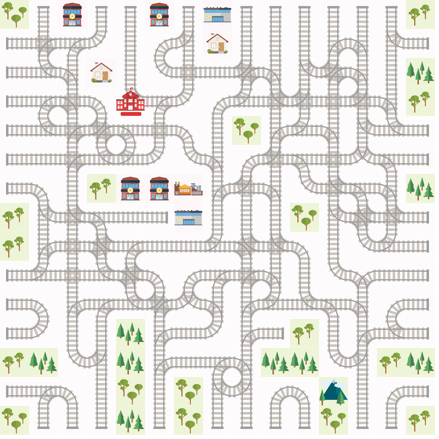

In [3]:
import PIL
from flatland.utils.rendertools import RenderTool
from IPython.display import clear_output


# Render the environment
def render_env(env,wait=True):
    
    env_renderer = RenderTool(env, gl="PILSVG")
    env_renderer.render_env()

    image = env_renderer.get_image()
    pil_image = PIL.Image.fromarray(image)
    clear_output(wait=True)
    display(pil_image)

render_env(random_env)

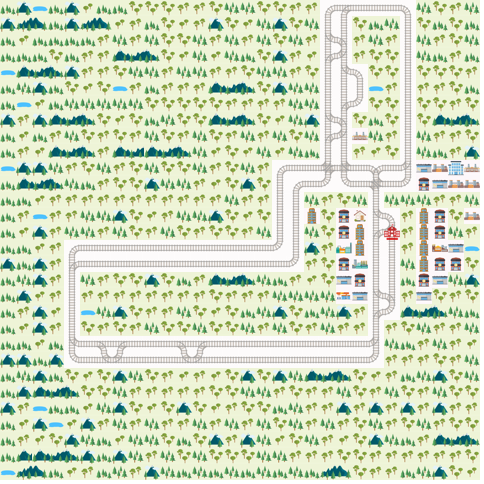

In [4]:
from flatland.envs.rail_generators import sparse_rail_generator

# More realistic networks can be built using sparse_rail_generator
sparse_env = RailEnv(
    width=30,
    height=30,
    rail_generator=sparse_rail_generator(
        max_num_cities=3,  # Number of cities (= train stations)
        grid_mode=False,  # Distribute the cities evenly in a grid
        max_rails_between_cities=2,  # Max number of rails connecting to a city
        max_rails_in_city=3  # Number of parallel tracks in cities
    ),
    number_of_agents=1
)

observation, info = sparse_env.reset()

render_env(sparse_env)

Environments can also be created from fixed configurations
Here we define a 6x4 railway from a 2D array

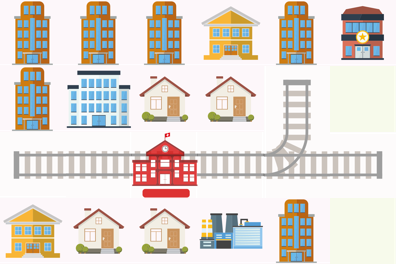

In [14]:
import numpy as np
from flatland.envs.rail_generators import rail_from_manual_specifications_generator

specs = [[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)],
         [(0, 0), (0, 0), (0, 0), (0, 0), (7, 0), (0, 0)],
         [(7, 270), (1, 90), (1, 90), (1, 90), (2, 90), (7, 90)],
         [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]]

rail_shape = np.array(specs).shape

fixed_env = RailEnv(
    width=rail_shape[1],
    height=rail_shape[0],
    rail_generator=rail_from_manual_specifications_generator(specs),
    number_of_agents=1
)

observation, info = fixed_env.reset()
render_env(fixed_env)

## Observations

The environment provides very complete observations by default. You typically won't use this object as-is. One of the main objectives of the Flatland challenge is to **find suitable observations** to solve the task at hand.

![stock observations](https://i.imgur.com/oo8EIYv.png)

By default, the environment provides global observations.


In [6]:
import numpy as np

for agent_handle in random_env.get_agent_handles():
    print('Observations for agent {}:'.format(agent_handle))
    agent_obs = observation[agent_handle]

    print('- Transition map\n{}\n'.format(np.transpose(agent_obs[0], (2, 0, 1))))
    print('- Agent position\n{}\n'.format(np.transpose(agent_obs[1], (2, 0, 1))))
    print('- Agent target \n{}\n'.format(np.transpose(agent_obs[2], (2, 0, 1))))

Observations for agent 0:
- Transition map
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 1. 1. 1. 1. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0

## The Agent

`RailEnv` is targeted at multi-agents experiments. For this purpose, it is derived from RLLib's `MultiAgentEnv` class. You can [read more details about it here](https://ray.readthedocs.io/en/latest/rllib-env.html).

The environment is run by supplying the `step` function with a **dictionary** of actions, whose keys are agents’ handles and the corresponding values are the selected actions. This dictionary is passed to the environment which checks the validity of all actions and update the environment state.

The environment returns an array of new observations, a reward dictionary for all the agents as well as a flags indicating which agents are done. This information can be used to update the policy of your agent and if `done[‘__all__’] == True` the episode terminates.

Let us implement a simple agent that takes a valid random action at each step.

In [7]:
class RandomController:
    def __init__(self, action_size):
        self.action_size = action_size

    def act(self, observations):
        actions = dict()
        for agent_handle, observation in enumerate(observations):
            action = np.random.randint(self.action_size)
            actions.update({agent_handle: action})
        return actions

The environment provides a openai gym-like interface.

The env simulation moves forward with the step() method which takes a dictionary of valid actions and returns the following
- observations represeting the state of the env and the **observation generator**
- rewards - the score that rates the agent's performance 
- status of compeletion of tasks for each agent
- additional information regarding the status of the env 

In the example below, we use `env.get_agent_handles()` to enumerate through the handles, and `RailEnvActions.to_char` to get a symbol representing the agent's direction: **B**ackward, **F**orward, **L**eft, **R**ight or **S**top.

In [8]:
from flatland.envs.rail_env import RailEnvActions

controller = RandomController(random_env.action_space[0])
observations, info = random_env.reset()
actions = controller.act(observations)

# Perform a single action per agent
for (handle, action) in actions.items():
    print('Agent {} will perform action {} ({})'.format(handle, action, RailEnvActions.to_char(action)))
    next_obs, all_rewards, dones, info = random_env.step({handle: action})

print('Rewards for each agent: {}'.format(all_rewards))
print('Done for each agent: {}'.format(dones))
print('Misc info: {}'.format(info))

Agent 0 will perform action 4 (S)
Rewards for each agent: {0: -1.0}
Done for each agent: {0: False, '__all__': False}
Misc info: {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.READY_TO_DEPART: 0>}}


In [9]:
def run_episode(env):
    controller = RandomController(env.action_space[0])
    observations, info = env.reset()

    score = 0
    actions = dict()

    for step in range(50):

        actions = controller.act(observations)
        next_observations, all_rewards, dones, info = env.step(actions)
        for agent_handle in env.get_agent_handles():
            score += all_rewards[agent_handle]

        render_env(env)
        print('Timestep {}, total score = {}'.format(step, score))

        if dones['__all__']:
            print('All done!')
            return

    print("Episode didn't finish after 50 timesteps.")

### Run an episode in the random environment

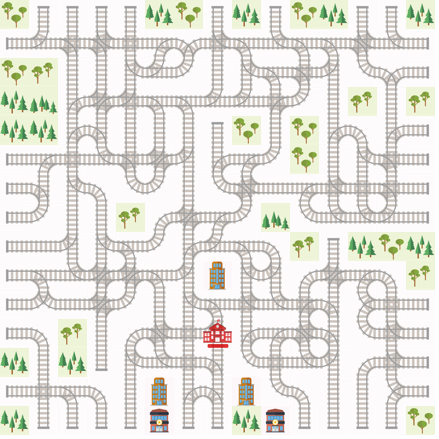

Timestep 5, total score = -4.0
All done!


In [10]:
run_episode(random_env)

### Run an episode in the sparse environment

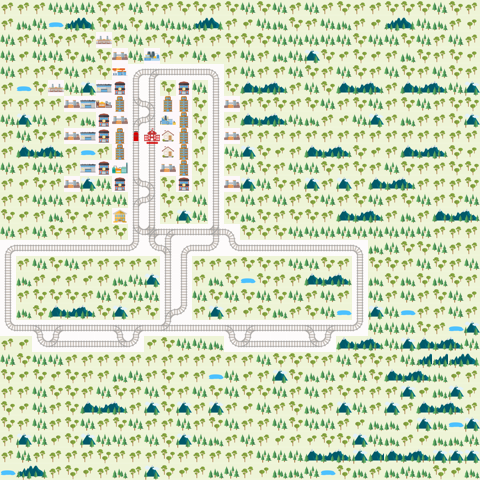

Timestep 49, total score = -50.0
Episode didn't finish after 50 timesteps.


In [11]:
run_episode(sparse_env)

### Run an episode in the fixed environment

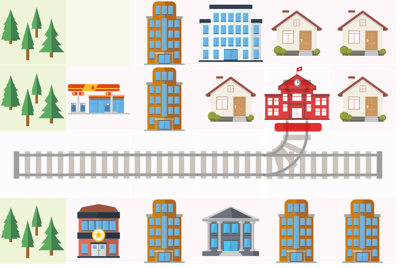

Timestep 20, total score = -19.0
All done!


In [17]:
run_episode(fixed_env)